In [1]:
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils  import to_categorical
from datetime     import datetime
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

Using TensorFlow backend.


In [2]:
data_dir = 'numpy_arrays'
X  = 'train_picture_features.npy'
y  = 'train_picture_labels.npy'

train_features = np.load(os.path.join(data_dir, X))
train_labels   = np.load(os.path.join(data_dir, y))

print("Features:",train_features.shape)
print("Labels", train_labels.shape)

Features: (33402,)
Labels (33402,)


In [3]:
# Preprocessing features
from skimage.transform import resize

%matplotlib inline

def resize_images(arrays, side_length):
    
    array_count = arrays.shape[0]
    template    = np.zeros((side_length, side_length,3))
    all_arrays = []
    
    for array in arrays:
        
        #print(array.shape)
        height, width = array.shape[0], array.shape[1]
        if height > width:
            new_height = side_length
            diff       = side_length / height
            new_width  = width * diff
        else:
            new_width  = side_length
            diff       = side_length / width
            new_height = height * diff
            
            tmp            = resize(array, (int(new_height), int(new_width), 3), mode='constant')
            top_padding    = np.zeros((int((side_length - tmp.shape[0]) / 2), side_length, 3))
            bottom_padding = np.zeros((int(side_length - top_padding.shape[0] - tmp.shape[0]) , side_length, 3))
 
            #print(top_padding.shape)
            #print(tmp.shape)
            #print(bottom_padding.shape)
            final = np.concatenate((top_padding, tmp, bottom_padding))
            #print(final.shape)
        
        all_arrays.append(final)
    
    return np.array(all_arrays)

def crop(arrays, new_width):
    ratio_max = 0.0
    ratio_min = np.inf
    
    for i, array in enumerate(arrays):
        print(array.shape)
        if i > 20:
            break
        height, width = array.shape[0], array.shape[1]
        ratio = height / (1.0 * width)
        ratio_max = max(ratio_max, ratio)
        ratio_min = min(ratio_min, ratio)

    print("MAX: ", ratio_max)
    print("MIN: ", ratio_min)
#################################

def resize_32x32(features):
    return np.array([resize(f, (32, 32, 3), mode='constant') for f in features])

def resize_64x64(features):
    return np.array([resize(f, (64, 64, 3), mode='constant') for f in features])

resized_images = resize_32x32(train_features)

print(resized_images.shape)

(33402, 32, 32, 3)


In [4]:
# Preprocessing targets

def list_to_arrays(labels):
    return np.array([np.array(label) for label in labels])

def remove_val(labels, in_val, out_val):
    for label in labels:
        label[label == in_val] = out_val
    
    return labels
    #return np.where(labels==in_val, out_val, labels) 

def pad_labels(train_labels):
    print(train_labels.shape)
    max_len = 0
    
    for arr in train_labels:
        max_len = max(len(arr), max_len)

    print("MAX LENGTH: {}".format(max_len))
    
    return np.array([arr + ((max_len - len(arr)) * [10.0]) for arr in train_labels])     

def one_hot_encoding(labels):
    return np.array([ to_categorical(label, num_classes=11) for label in labels])

label_lengths = to_categorical(np.array([len(label) for label in train_labels]))
print(label_lengths.shape)
print(label_lengths[1])
print(label_lengths[2])
print(label_lengths[-1])

(33402, 7)
[ 0.  0.  1.  0.  0.  0.  0.]
[ 0.  0.  1.  0.  0.  0.  0.]
[ 0.  0.  0.  1.  0.  0.  0.]


In [22]:
def dense_model(in_shape):
    model = Sequential()
    model.add(Dense(32, input_shape=in_shape))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(192))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(7))
    model.add(Activation('softmax'))
    model.summary()
    return model
    
def pooling_model(in_shape):
    model = Sequential()
    model.add(Conv2D(filters=48, kernel_size=2, padding='same', activation='relu', input_shape=in_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=160, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=192, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.summary()
    return model

In [26]:
features = resized_images
targets  = label_lengths
model    = pooling_model(features.shape[1:])

print("INPUT SHAPE: {}".format(features.shape))
print("OUTPUT SHAPE: {}".format(targets.shape))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 48)        624       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 48)        192       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        12352     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         32896     
__________

In [27]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
from keras.callbacks import ModelCheckpoint
from time import time

start      = time()
epochs     = 10
time_now   = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join('models', 'model_multidigitlength_' + str(epochs) + 'epochs_' + time_now +'.hdf5')

print("MODEL FILE: {}".format(model_path))

checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, save_best_only=True, monitor='acc',)

model.fit(features, targets
          , epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

print("TIME: {}".format(time() - start))

MODEL FILE: models/model_multidigitlength_10epochs_20190627_020125.hdf5
Epoch 1/10
33402/33402 [==============================] - 123s - loss: 0.8905 - acc: 0.6194   
Epoch 2/10
33402/33402 [==============================] - 123s - loss: 0.6669 - acc: 0.7282   
Epoch 3/10
33402/33402 [==============================] - 122s - loss: 0.5851 - acc: 0.7664   
Epoch 4/10
33402/33402 [==============================] - 122s - loss: 0.5391 - acc: 0.7890   
Epoch 5/10
33402/33402 [==============================] - 123s - loss: 0.5050 - acc: 0.8018   
Epoch 6/10
33402/33402 [==============================] - 123s - loss: 0.4753 - acc: 0.8131   
Epoch 7/10
33402/33402 [==============================] - 123s - loss: 0.4500 - acc: 0.8261   
Epoch 8/10
33402/33402 [==============================] - 124s - loss: 0.4214 - acc: 0.8373   
Epoch 9/10
33402/33402 [==============================] - 125s - loss: 0.3945 - acc: 0.8467   
Epoch 10/10
33402/33402 [==============================] - 126s - loss: 0

In [29]:
def predict(array_set):
    y_pred = model.predict(array_set)
    return np.array([np.argmax(i) for i in y_pred])

def get_length_accuracy(predictions, labels):
    correct = 0
    for i, pred in enumerate(predictions):
        if pred == len(labels[i]):
            correct += 1
            
    return (correct*1.0) / len(predictions)

PREDICTIONS: [2 2 1]
LABELS: [[1.0, 9.0] [2.0, 3.0] [2.0, 5.0]]
[[ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]]


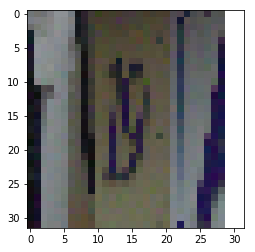

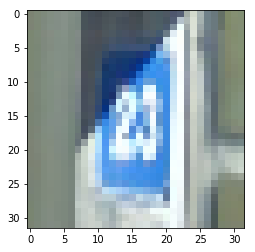

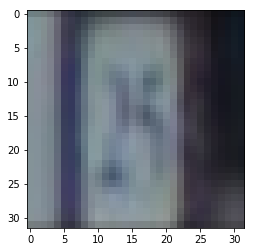

In [30]:
test_set    = resized_images[:3]
predictions = predict(test_set)

print("PREDICTIONS: {}".format(predictions))
print("LABELS: {}".format(train_labels[:3]))
print(label_lengths[:3])

for img in test_set:
    fig,ax  = plt.subplots(1)
    ax.imshow(img)

In [31]:
# Testing
test_features = np.load(os.path.join(data_dir, 'test_picture_features.npy'))
test_labels   = np.load(os.path.join(data_dir, 'test_picture_labels.npy'))

In [32]:
resized_test_images = resize_32x32(test_features)

In [33]:
test_predictions = predict(resized_test_images)

In [34]:
print("Accuracy: {}".format(get_length_accuracy(test_predictions, test_labels)*100))

Accuracy: 62.98591980410162


Accuracy: 66.66666666666666
1 [5.0]
1 [2.0, 1.0, 10.0]
1 [6.0]


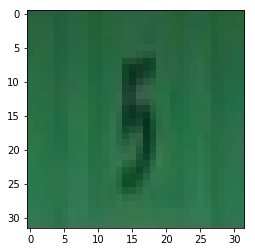

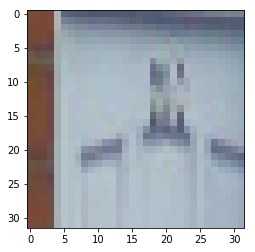

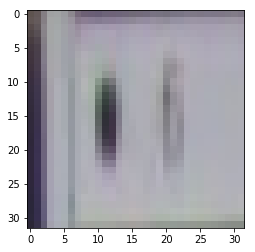

In [35]:
samples     = 3
test_set    = resized_test_images[:samples]
predictions = predict(test_set)
print("Accuracy: {}".format(get_length_accuracy(predictions, test_labels[:samples])*100))

for i, img in enumerate(test_set):
    print(predictions[i], test_labels[i])
    fig,ax  = plt.subplots(1)
    ax.imshow(img)